In [1]:
import os
import pickle

import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
DATA_LOAD = True

TRAIN_PREDICTIONS_FILENAME = "../runs/resnext101_v3/resnext101_v3_train_predictions.pkl"
TRAIN_GROUD_TRUE = "../data/train/landmarks.csv"
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [3]:
noisy_path = os.path.join('../data/train', 'noisy.txt')
with open(noisy_path, "rb") as fp:
    noisy_file = pickle.load(fp)

In [4]:
df = pd.read_csv(TRAIN_GROUD_TRUE, sep='\t')
df = df[~df['file_name'].isin(noisy_file)]
print(f"Train Dataset: {len(df)}")

Train Dataset: 58359


In [5]:
with open(TRAIN_PREDICTIONS_FILENAME, "rb") as fp:
    results = pickle.load(fp)
image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

Images: 58359
Landmarks shape: (58359, 971, 2)


In [6]:
def make_landmarks(row):
    landmark = row[1:]
    land_mark_len = landmark.shape[0]
    landmark = landmark.reshape(int(land_mark_len/2), 2)
    return landmark

In [7]:
def draw_landmarks(image, landmarks, ground_true):
    for point in ground_true:
        x, y = point.astype(int)
        cv2.circle(image, (x, y), 1, (0, 128, 0), 1, -1)
    for point in landmarks:
        x, y = point.astype(int)
        cv2.circle(image, (x, y), 1, (128, 0, 0), 1, -1)
    return image

In [8]:
if DATA_LOAD:
    df = pd.read_csv('../data/train/error_ground_true.csv', index_col=0)
    df['MSE'] = df['MSE'].apply(abs)
else:
    error = []
    for i in tqdm(range(len(image_names))):
        image = cv2.imread('../' + image_names[i])
        image_name = image_names[i].split('/')[-1]
        train_land = make_landmarks(df[df['file_name'] == image_name].iloc[0].values)
        predict_land = landmarks[i]
        error.append(np.mean(train_land - predict_land))
    df['MSE'] = error
    df['MSE'] = df['MSE'].apply(abs)
    df.to_csv('../data/train/error_ground_true.csv')

In [9]:
df.reset_index(inplace=True)

In [10]:
len_ind = min(NUM_IMAGES_TO_SHOW, len(image_names))
ind = df.sort_values('MSE', ascending=False).index[:len_ind]

In [11]:
def make_landmarks(row):
    landmark = row[2:-1]
    land_mark_len = landmark.shape[0]
    landmark = landmark.reshape(int(land_mark_len/2), 2)
    return landmark

In [12]:
ROW_NUM, COL_NUM = 5, 10

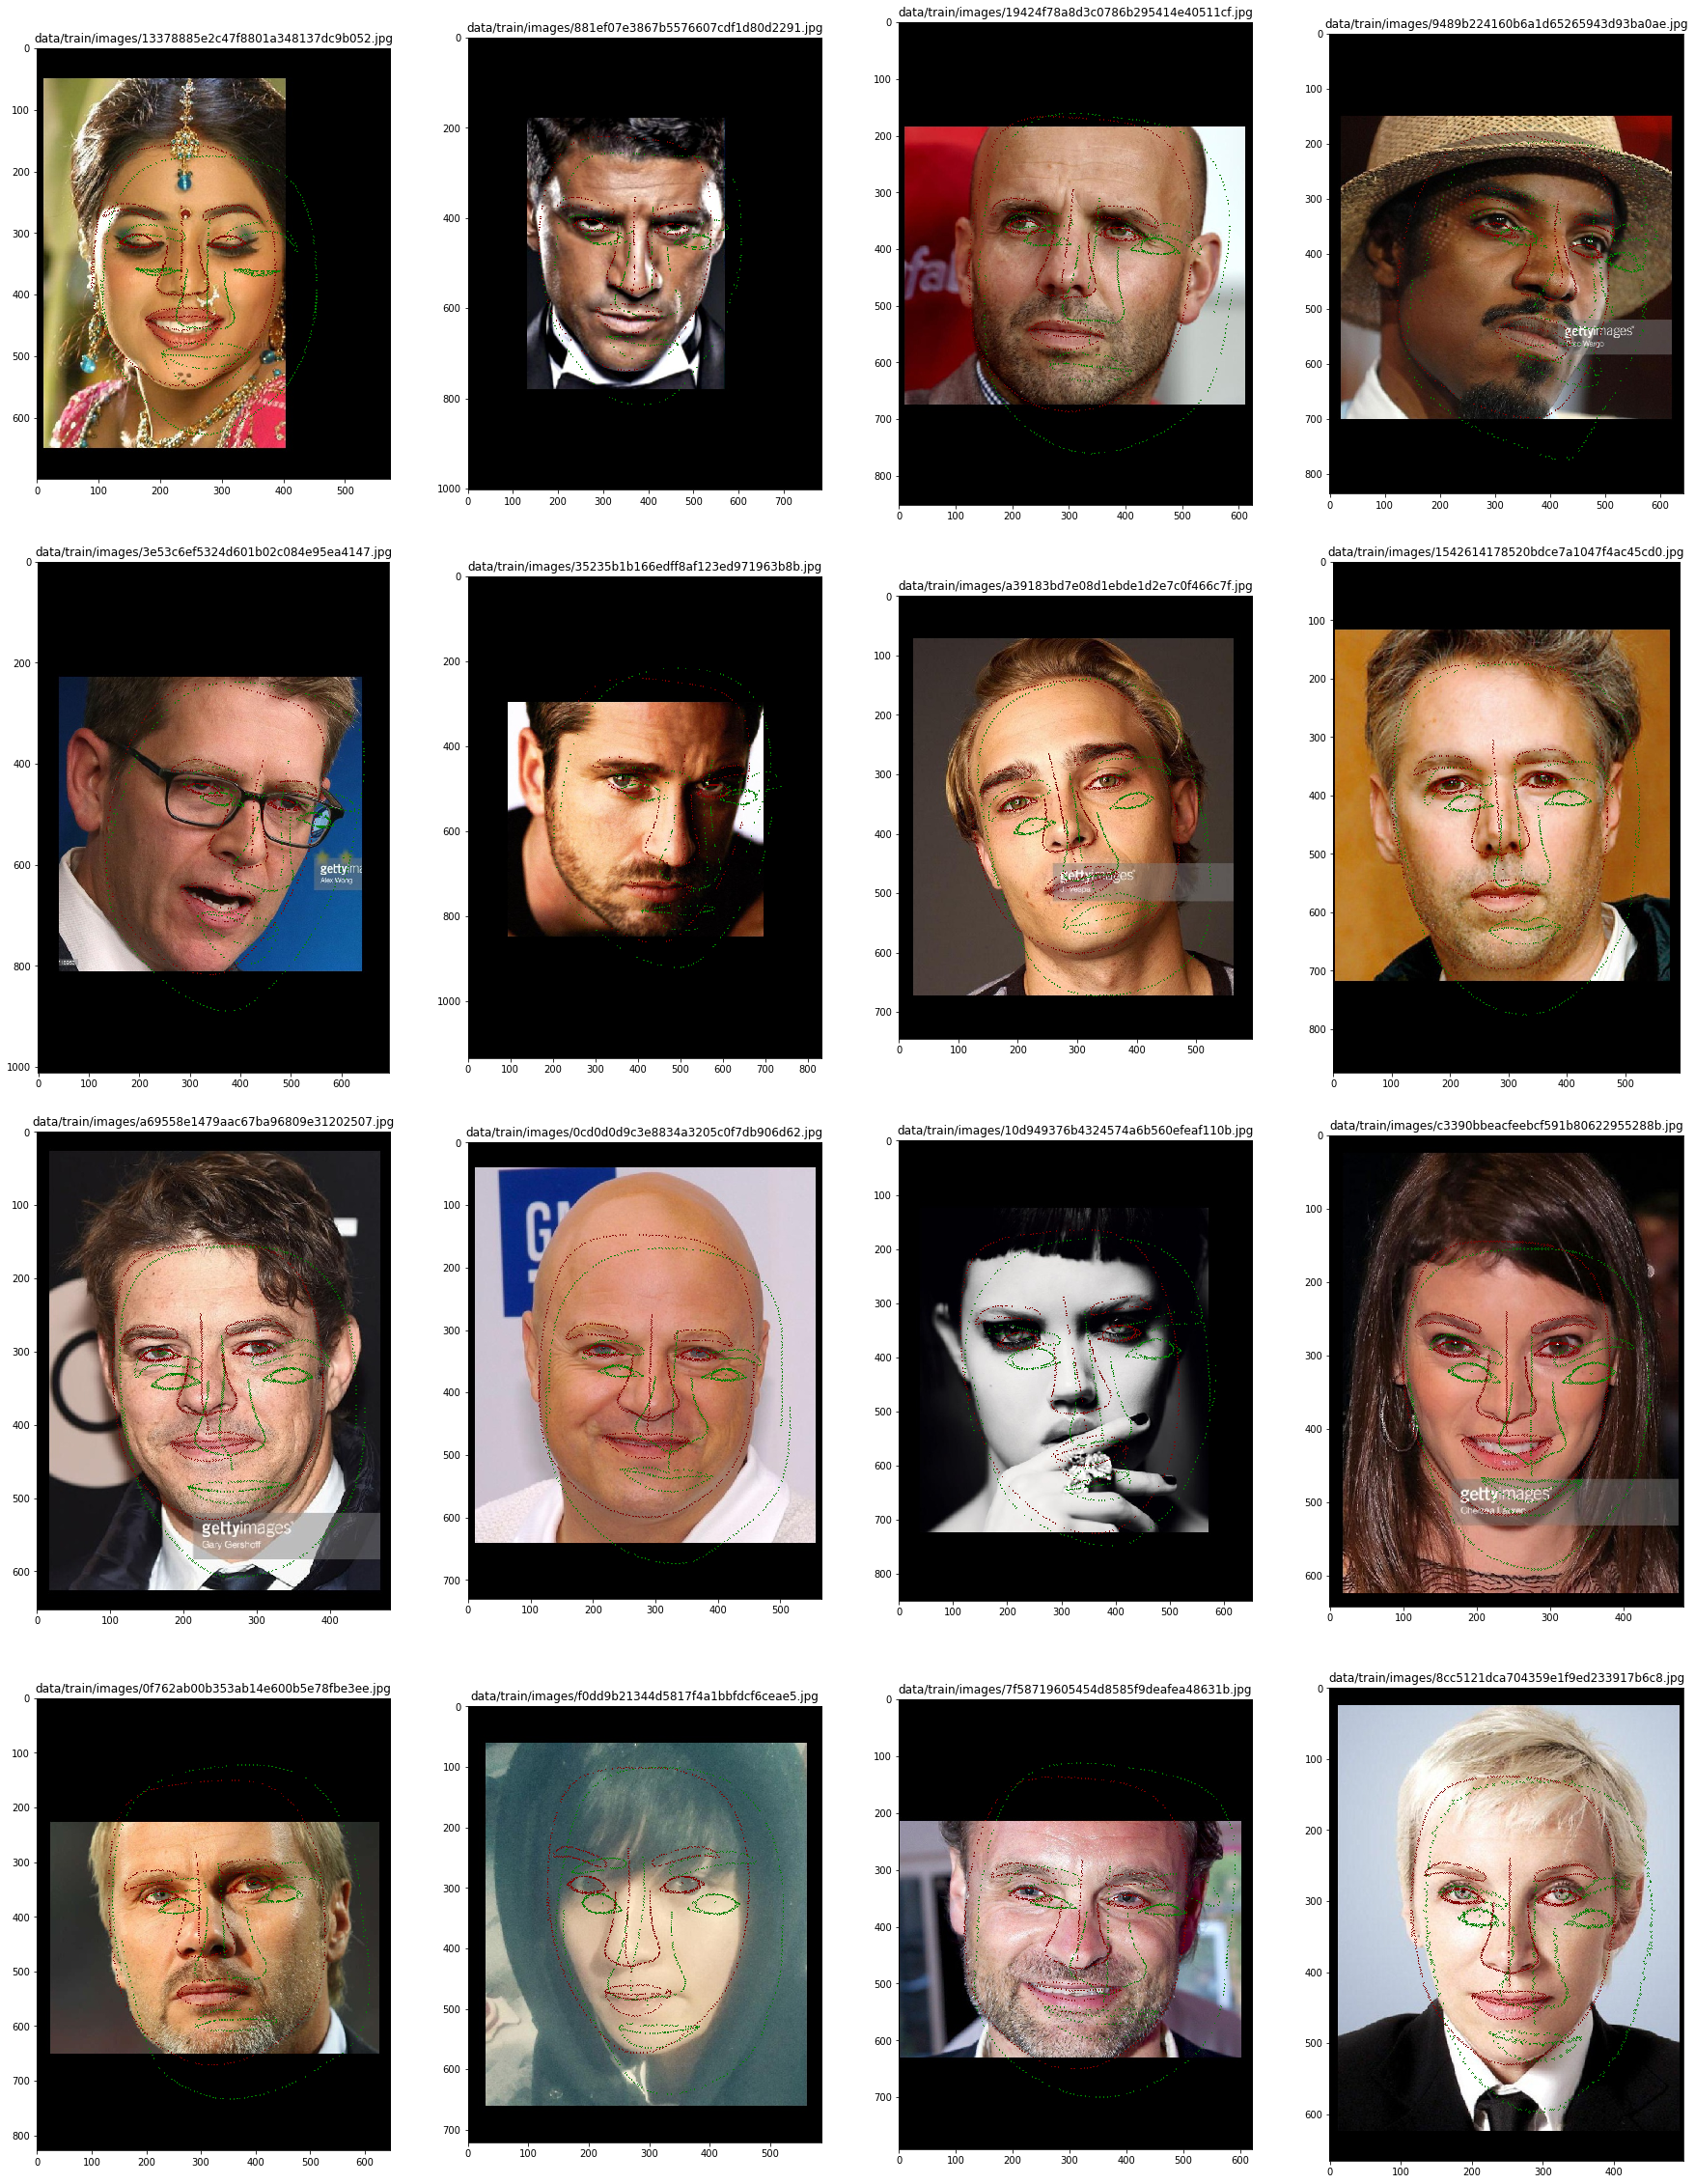

In [13]:
plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(ind, 1):
    image = cv2.imread('../' + image_names[idx])
    image_name = image_names[idx].split('/')[-1]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx], make_landmarks(df[df['file_name'] == image_name].iloc[0].values))
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)
    plt.title(image_names[idx])
    
plt.tight_layout()
plt.show()

In [14]:
len_ind = min(NUM_IMAGES_TO_SHOW, len(image_names))
print(len_ind)
ind = df.sort_values('MSE', ascending=False).index[len_ind * 40:len_ind * 41]

16


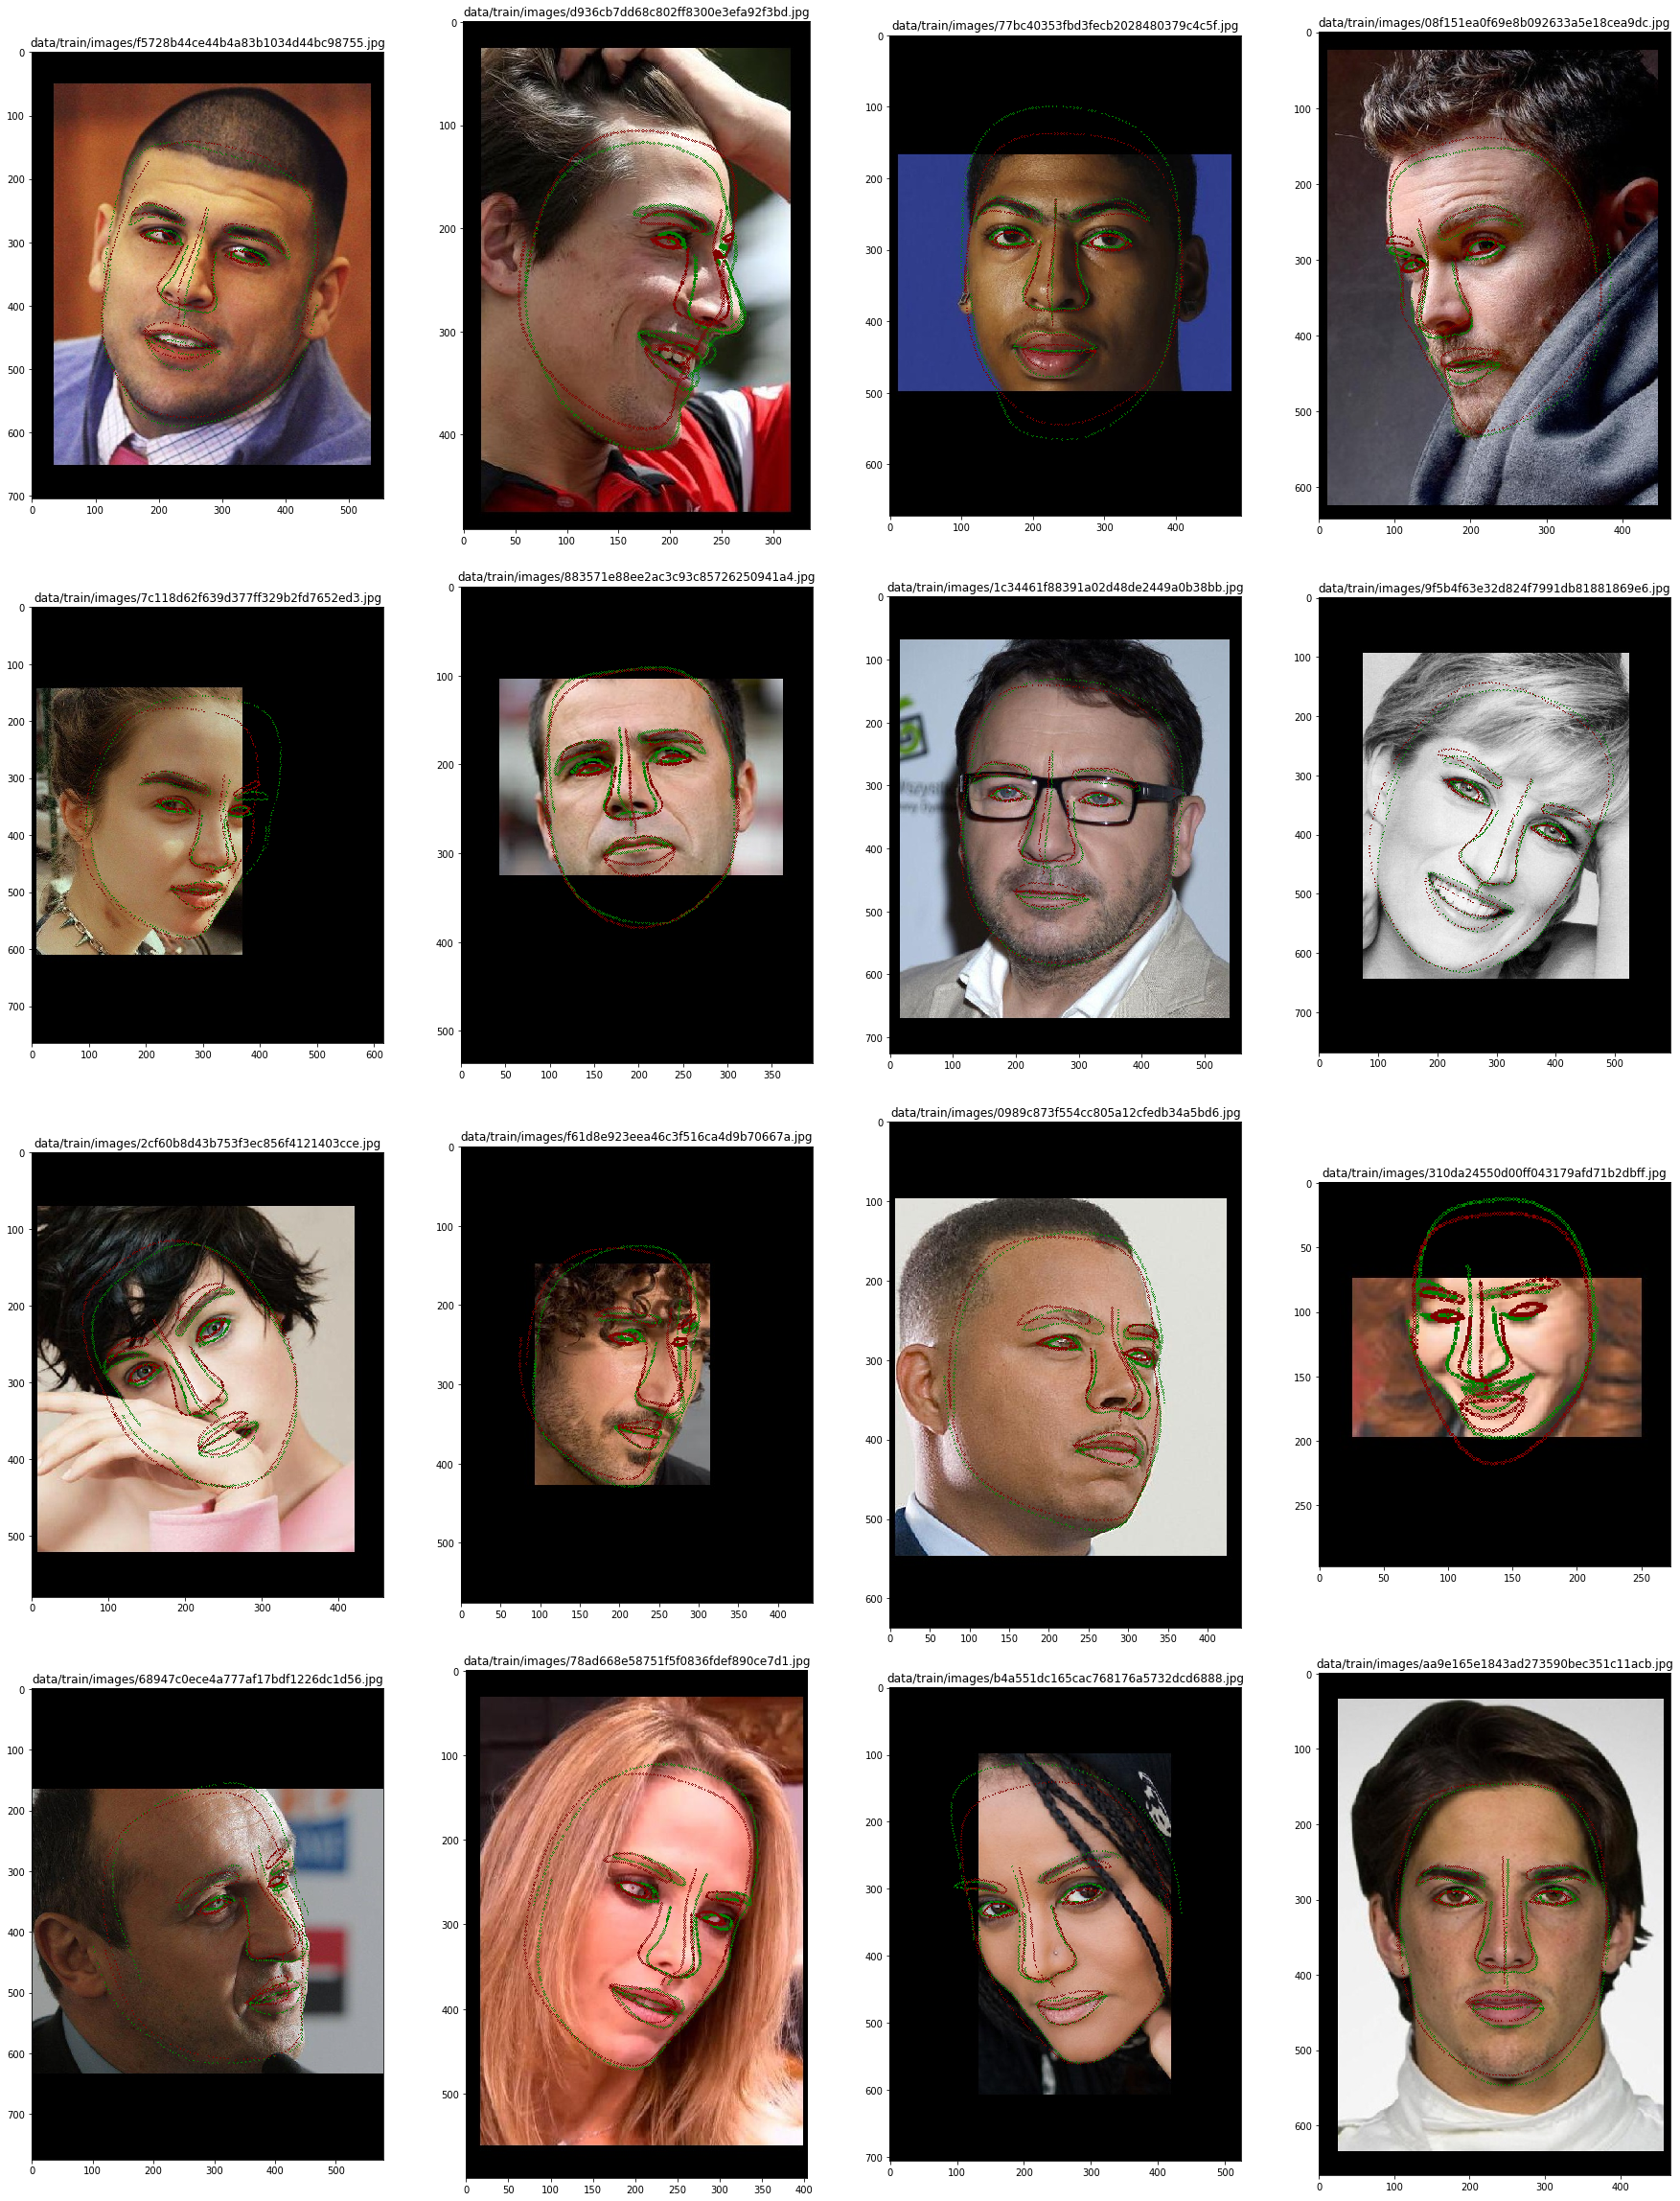

In [15]:
plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(ind, 1):
    image = cv2.imread('../' + image_names[idx])
    image_name = image_names[idx].split('/')[-1]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx], make_landmarks(df[df['file_name'] == image_name].iloc[0].values))
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)
    plt.title(image_names[idx])
    
plt.tight_layout()
plt.show()

In [16]:
shift_image = df.sort_values('MSE', ascending=False).iloc[:len_ind * 41]

In [17]:
shift_file = shift_image['file_name'].values

In [18]:
with open("../data/train/shift_file.txt", "wb") as fp:
    pickle.dump(shift_file, fp)